In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Load Data
data = pd.read_excel(r"C:\Users\pppat\Downloads\Climate_Indices-main\Climate_Indices-main\concatenated_rain_data.xlsx")
# data = data.set_index(pd.date_range('01-1998', periods=len(data), freq='M'))
data.head(10)

,no,station_id,station_name,month_year,day1,day2,day3,day4,day5,day6,...,day23,day24,day25,day26,day27,day28,day29,day30,day31,sum
0,1,300201,แม่ฮ่องสอน จ.แม่ฮ่องสอน,01-1998,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,300201,แม่ฮ่องสอน จ.แม่ฮ่องสอน,02-1998,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,300201,แม่ฮ่องสอน จ.แม่ฮ่องสอน,03-1998,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.9,0.7,0.0,3.6
3,4,300201,แม่ฮ่องสอน จ.แม่ฮ่องสอน,04-1998,0.0,0.0,0.0,2.6,3.9,0.0,...,0.0,0.0,0.0,0.0,11.3,0.0,0.0,0.0,0.0,22.7
4,5,300201,แม่ฮ่องสอน จ.แม่ฮ่องสอน,05-1998,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.1,6.3,18.5,6.1,10.3,0.0,66.1,171.1
5,6,300201,แม่ฮ่องสอน จ.แม่ฮ่องสอน,06-1998,8.3,0.0,0.0,0.0,0.0,68.5,...,6.3,3.9,0.5,0.0,0.0,0.6,5.6,1.4,0.0,114.2
6,7,300201,แม่ฮ่องสอน จ.แม่ฮ่องสอน,07-1998,0.0,8.5,7.8,5.4,19.7,3.1,...,0.0,7.8,3.0,1.2,3.6,0.0,0.0,0.0,9.1,165.6
7,8,300201,แม่ฮ่องสอน จ.แม่ฮ่องสอน,08-1998,17.1,10.0,0.6,2.2,0.0,0.0,...,11.0,1.6,36.5,0.2,5.3,0.0,0.0,1.2,6.7,243.5
8,9,300201,แม่ฮ่องสอน จ.แม่ฮ่องสอน,09-1998,0.0,0.8,4.0,12.8,26.3,16.7,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,157.7
9,10,300201,แม่ฮ่องสอน จ.แม่ฮ่องสอน,10-1998,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.5,1.0,1.9,0.0,5.9,0.0,29.0


In [7]:
#ลิสชื่อสถานี
stations = list(data.columns)
print(stations)

['no', 'station_id', 'station_name', 'month_year', 'day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'day10', 'day11', 'day12', 'day13', 'day14', 'day15', 'day16', 'day17', 'day18', 'day19', 'day20', 'day21', 'day22', 'day23', 'day24', 'day25', 'day26', 'day27', 'day28', 'day29', 'day30', 'day31', 'sum']


In [8]:
#ฟังชันคำนวณ spi
#Standardized Precipitation Index Function
def spi(ds, thresh):
    #ds - data ; thresh - time interval / scale

    #Rolling Mean / Moving Averages
    ds_ma = ds.rolling(thresh, center=False).mean()

    #Natural log of moving averages
    ds_In = np.log(ds_ma)
    ds_In[ np.isinf(ds_In) == True] = np.nan  #Change infinity to NaN

    #Overall Mean of Moving Averages
    ds_mu = np.nanmean(ds_ma)

    #Summation of Natural log of moving averages
    ds_sum = np.nansum(ds_In)

    #Computing essentials for gamma distribution
    n = len(ds_In[thresh-1:])                  #size of data
    A = np.log(ds_mu) - (ds_sum/n)             #Computing A
    alpha = (1/(4*A))*(1+(1+((4*A)/3))**0.5)   #Computing alpha  (a)
    beta = ds_mu/alpha                         #Computing beta (scale)

    #Gamma Distribution (CDF)
    gamma = st.gamma.cdf(ds_ma, a=alpha, scale=beta)

    #Standardized Precipitation Index   (Inverse of CDF)
    norm_spi = st.norm.ppf(gamma, loc=0, scale=1)  #loc is mean and scale is standard dev.

    return ds_ma, ds_In, ds_mu, ds_sum, n, A, alpha, beta, gamma, norm_spi

In [10]:
stations = list(data.columns)[3:]
time = 3 #it can define month by changing thr number such as spi 6. Puting 6 instead of 3
spi_data = pd.DataFrame()
spi_data['month/year'] = data.index
for station in stations:
  x = spi(data[station], time) # ส่งผ่านเฉพาะคอลัมน์ตัวเลขสำหรับแต่ละสถานี
  spi_data['spi_'+str(station)] = x[9]

DataError: No numeric types to aggregate

In [ ]:
#data.fillna(-np.inf, 0, inplace=True)
#spi_data.head(31)

In [ ]:
#times = [3, 6, 9, 12, 24]
#for i in times:
 #   x = spi(data['station'], i)
  #  data['spi_'+str(i)] = x[9]
times = [3, 6, 9, 12, 24]
for i in times:
    x = spi(data[station], i) # ใช้ตัวแปร station เพื่อเลือกคอลัมน์ที่ถูกต้อง
    data['spi_'+str(i)] = x[9]

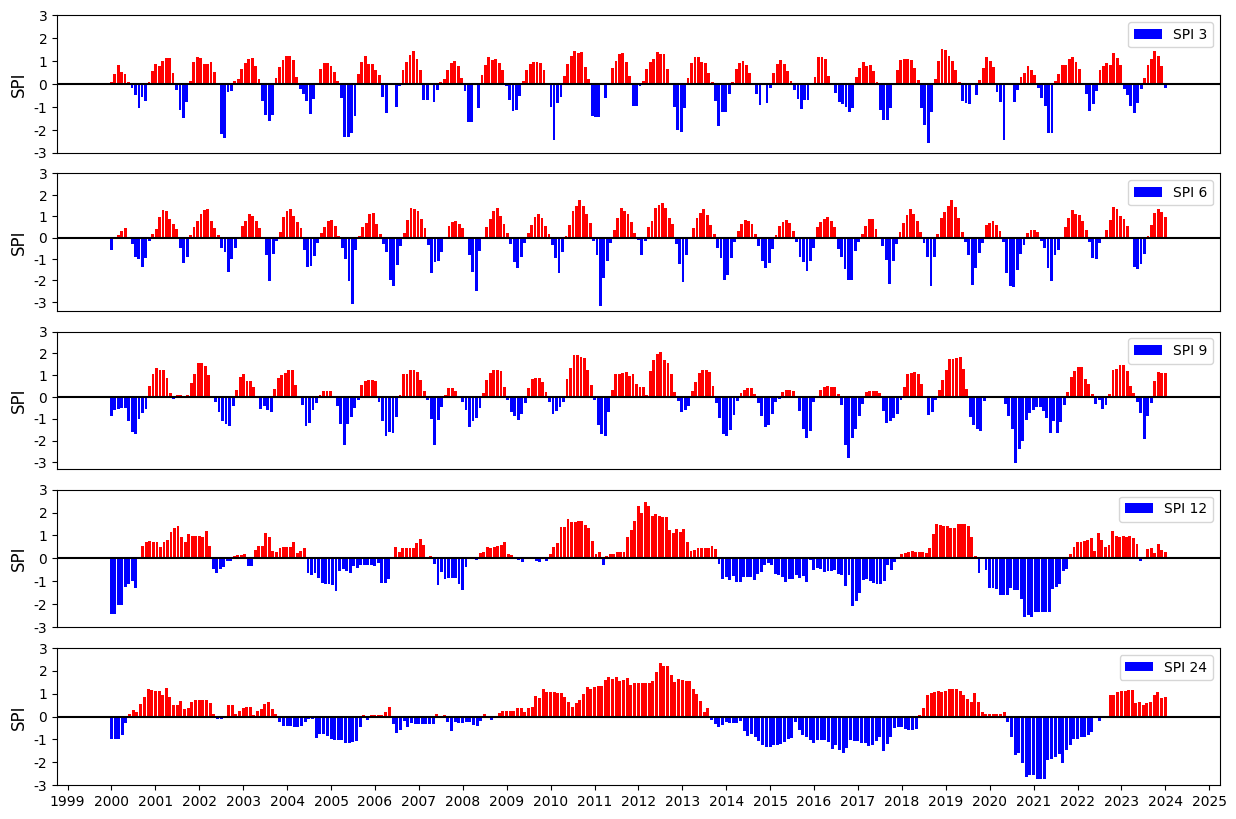

In [ ]:
fig, axes = plt.subplots(nrows=5, figsize=(15, 10))
plt.subplots_adjust(hspace=0.15)
for i, ax in enumerate(axes):

    col_scheme=np.where(data['spi_'+str(times[i])]>0, 'r','b')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.bar(data.index, data['spi_'+str(times[i])], width=25, align='center', color=col_scheme, label='SPI '+str(times[i]))
    ax.axhline(y=0, color='k')
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.legend(loc='upper right')
    ax.set_yticks(range(-3,4), range(-3,4))
    ax.set_ylabel('SPI', fontsize=12)

    if i<len(times)-1:
        ax.set_xticks([],[])

#for time in times:
 #   print(f"SPI values for period: {time} months")
  #  for index, row in data.iterrows():
   #     spi_value = row['spi_' + str(time)]
    #    print(f"Year: {index.year}, Month: {index.month}, SPI: {spi_value:.2f}")
    #print()  # แยกข้อมูลของแต่ละช่วงเวลาออกจากกัน


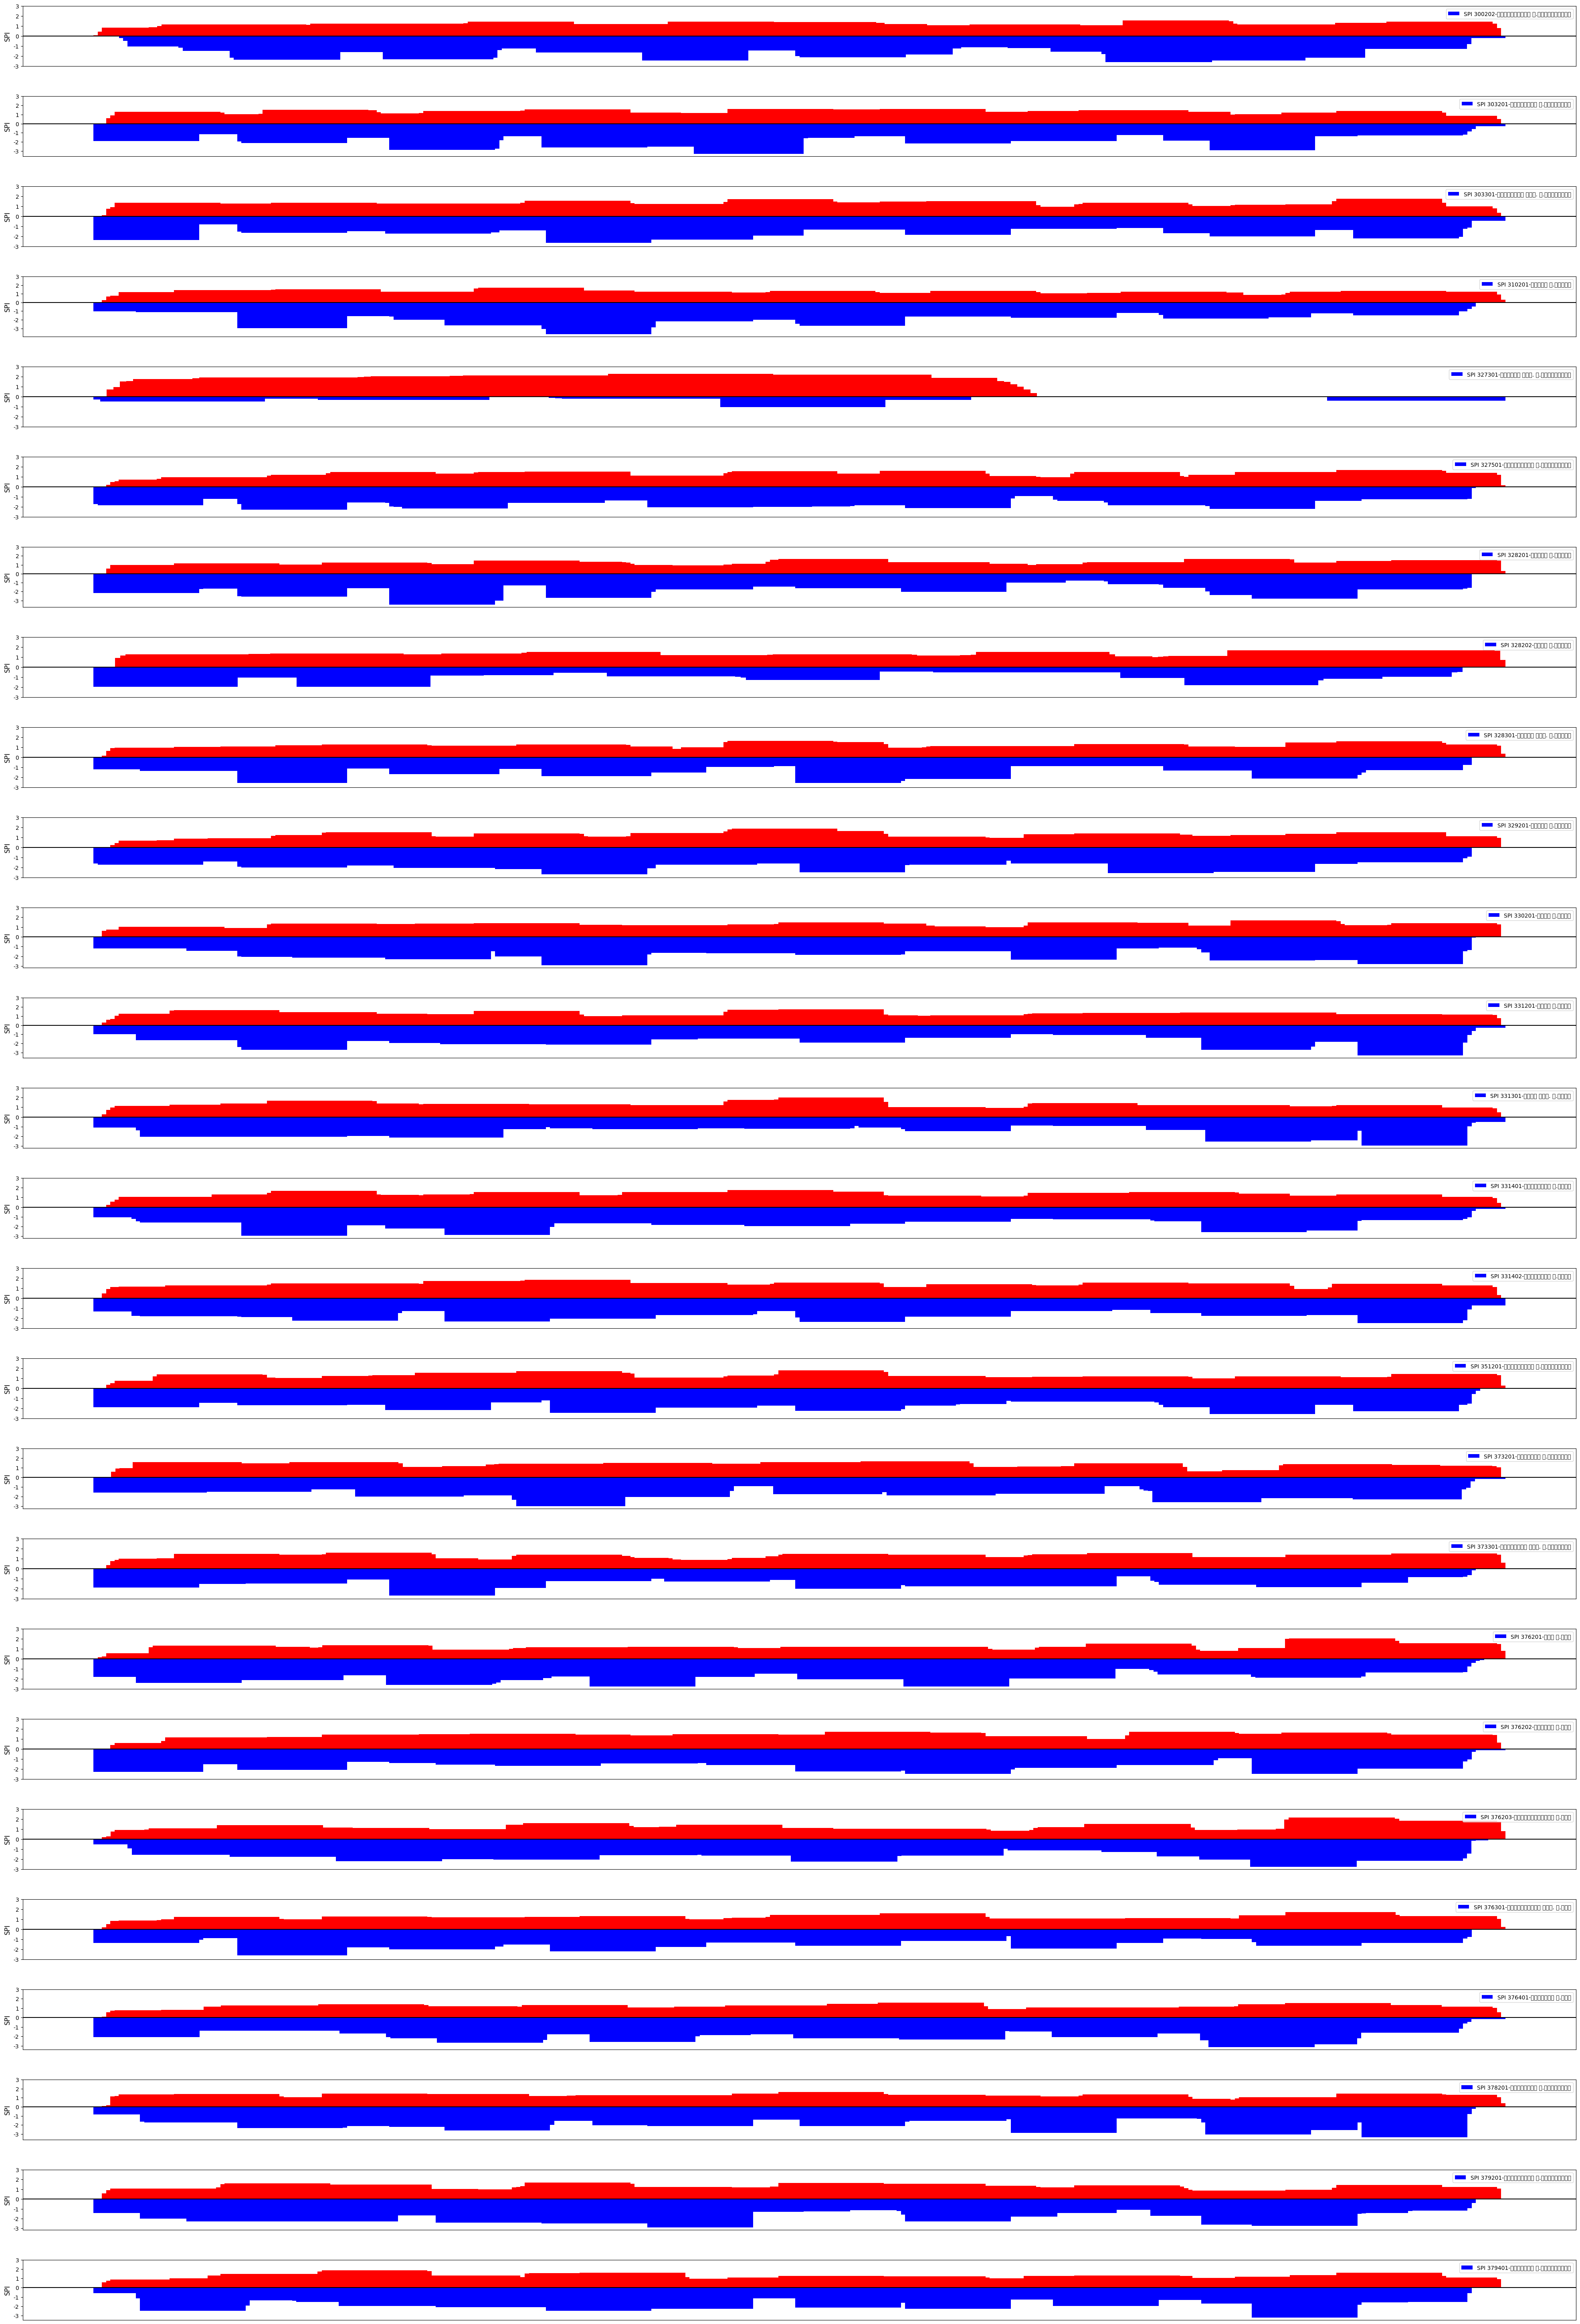

In [ ]:
fig, axes = plt.subplots(nrows=26, figsize=(50, 75))
plt.subplots_adjust(hspace=0.5)

for station, ax in zip(stations, axes):
    col_scheme = np.where(spi_data['spi_'+str(station)] > 0, 'r', 'b')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.bar(spi_data.index, spi_data['spi_'+str(station)], width=25, align='center', color=col_scheme, label='SPI '+str(station))
    ax.axhline(y=0, color='k')
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.legend(loc='upper right')
    ax.set_yticks(range(-3, 4), range(-3, 4))
    ax.set_ylabel('SPI', fontsize=12)

   # if station != stations[-1]:
    ax.set_xticks([], [])

#plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=26, figsize=(50, 75))
plt.subplots_adjust(hspace=0.5)
#times = [1,2,3,4,5,6,7,8,9,10,11,12]
#for i, ax in enumerate(axes):
for station, ax in zip(stations, axes):
  #  ax.set_title(station, fontsize=16)
    col_scheme=np.where(data[str(stations)]>0,'r','b')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.bar(data.index, data[str(stations)], width=25, align='center', color=col_scheme, label=str(stations))
    ax.axhline(y=0, color='k')
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.legend(loc='upper right')
    ax.set_yticks(range(-3,4), range(-3,4))
    ax.set_ylabel('SPI', fontsize=12)

    # if i<len(stations)-1:
     #   ax.set_xticks([],[])

#for time in times:
 #   print(f"SPI values for period: {time} months")
  #  for index, row in data.iterrows():
   #     spi_value = row['spi_' + str(time)]
    #    print(f"Year: {index.year}, Month: {index.month}, SPI: {spi_value:.2f}")
    #print()  # แยกข้อมูลของแต่ละช่วงเวลาออกจากกัน


In [ ]:
stations = ['300202-แม่สะเรียง จ.แม่ฮ่องสอน', '303201-เชียงราย จ.เชียงราย', '303301-เชียงราย สกษ. จ.เชียงราย',
            '310201-พะเยา จ.พะเยา', '327301-แม่โจ้ สกษ. จ.เชียงใหม่', '327501-เชียงใหม่ จ.เชียงใหม่',
            '328201-ลำปาง จ.ลำปาง', '328202-เถิน จ.ลำปาง', '328301-ลำปาง สกษ. จ.ลำปาง',
            '329201-ลำพูน จ.ลำพูน', '330201-แพร่ จ.แพร่', '331201-น่าน จ.น่าน',
            '331301-น่าน สกษ. จ.น่าน', '331401-ท่าวังผา จ.น่าน', '331402-ทุ่งช้าง จ.น่าน',
            '351201-อุตรดิตถ์ จ.อุตรดิตถ์', '373201-สุโขทัย จ.สุโขทัย', '373301-ศรีสำโรง สกษ. จ.สุโขทัย',
            '376201-ตาก จ.ตาก', '376202-แม่สอด จ.ตาก', '376203-เขื่อนภูมิพล จ.ตาก',
            '376301-ดอยมูเซอร์ สกษ. จ.ตาก', '376401-อุ้มผาง จ.ตาก', '378201-พิษณุโลก จ.พิษณุโลก',
            '379201-เพชรบูรณ์ จ.เพชรบูรณ์', '379401-หล่มสัก จ.เพชรบูรณ์', '379402-วิเชียรบุรี จ.เพชรบูรณ์',
            '380201-กำแพงเพชร จ.กำแพงเพชร', '386301-พิจิตร สกษ. จ.พิจิตร']

fig, axes = plt.subplots(nrows=len(stations), figsize=(50, 75))
plt.subplots_adjust(hspace=0.5)

for station, ax in zip(stations, axes):
    col_scheme = np.where(data[station] > 0, 'r', 'b')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.bar(data.index, data[station], width=25, align='center', color=col_scheme, label=station)
    ax.axhline(y=0, color='k')
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.legend(loc='upper right')
    ax.set_yticks(range(-3, 4), range(-3, 4))
    ax.set_ylabel('SPI', fontsize=12)

    if station != stations[-1]:
        ax.set_xticks([], [])

plt.show()